In [151]:
# 同时添加如下代码, 这样每次环境(kernel)启动的时候只要运行下方代码即可: 
# Also add the following code, 
# so that every time the environment (kernel) starts, 
# just run the following code: 
import sys 
sys.path.append('/home/aistudio/external-libraries')

In [2]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

data211908


In [27]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

In [1]:
!unzip -qO UTF-8 data/data211908/地铁数据.zip -d ./data

In [152]:
import re
import pandas as pd 
# 查看客流量数据集
df = pd.read_csv('data/客流量数据.csv')
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234614 entries, 0 to 234613
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   时间      234614 non-null  int64 
 1   时间区段    234614 non-null  object
 2   站点      234614 non-null  object
 3   进站数量    234614 non-null  int64 
 4   出站数量    234614 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 8.9+ MB


,时间,时间区段,站点,进站数量,出站数量
0,20220101,00:00:00-00:14:59,G站,63,21
1,20220101,00:00:00-00:14:59,F站,42,84
2,20220101,00:00:00-00:14:59,E站,0,105
3,20220101,00:00:00-00:14:59,D站,42,126
4,20220101,00:00:00-00:14:59,C站,42,105


In [153]:
# 查看test数据集
tf = pd.read_csv('data/test.csv')
tf.info()
tf.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Time     672 non-null    object
 1   InNum    672 non-null    int64 
 2   OutNum   672 non-null    int64 
 3   Station  672 non-null    object
dtypes: int64(2), object(2)
memory usage: 21.1+ KB


,Time,InNum,OutNum,Station
0,2023/4/15 0:00,10,5,A
1,2023/4/15 0:15,2,1,A
2,2023/4/15 0:30,0,1,A
3,2023/4/15 0:45,0,0,A
4,2023/4/15 1:00,0,0,A


In [154]:
# 查看reslut数据集
rf = pd.read_csv('data/result.csv')
rf.info()
rf.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Time     672 non-null    object 
 1   InNum    0 non-null      float64
 2   OutNum   0 non-null      float64
 3   Station  672 non-null    object 
dtypes: float64(2), object(2)
memory usage: 21.1+ KB


,Time,InNum,OutNum,Station
0,2023/4/16 0:00,NaN,NaN,A
1,2023/4/16 0:15,NaN,NaN,A
2,2023/4/16 0:30,NaN,NaN,A
3,2023/4/16 0:45,NaN,NaN,A
4,2023/4/16 1:00,NaN,NaN,A


In [155]:
df.dtypes

时间       int64
时间区段    object
站点      object
进站数量     int64
出站数量     int64
dtype: object

通过对三个数据集的查看，发现客流量数据集的维度与测试数据不同，而reslut数据集与test数据集维度是相同的，因此要把客流量数据集的信息重新提取，只需把时间和时间区段相结合，也就是转换成时间序列模型，而时间区段都是相差15分钟，因此时间的话只要前面的开始时间，最后再把列名转换成英文，这样三个数据就符合了

In [156]:
def extract_station(x):
    station = re.compile('([A-Z])站').findall(x)
    if len(station)>0:
        return station[0]
df["时间区段"] = df["时间区段"].apply(lambda x:x.split("-")[0])
df["站点"] = df["站点"].apply(extract_station)
df["时间"] = df["时间"].apply(lambda x:str(x)).str.cat(df['时间区段'],sep=" ")
df["时间"] = pd.to_datetime(df["时间"])
df = df.drop("时间区段",axis=1)
df.columns =["Time", "Station", "InNum", "OutNum"] 



In [142]:
df['Time']


0        2022-01-01 00:00:00
1        2022-01-01 00:00:00
2        2022-01-01 00:00:00
3        2022-01-01 00:00:00
4        2022-01-01 00:00:00
                 ...        
234609   2023-03-31 23:45:00
234610   2023-03-31 23:45:00
234611   2023-03-31 23:45:00
234612   2023-03-31 23:45:00
234613   2023-03-31 23:45:00
Name: Time, Length: 234614, dtype: datetime64[ns]

In [162]:
df.head()

,Time,Station,InNum,OutNum
0,2022-01-01,G,63,21
1,2022-01-01,F,42,84
2,2022-01-01,E,0,105
3,2022-01-01,D,42,126
4,2022-01-01,C,42,105


一天一个站点的数据分析

In [144]:
# 自己改
start = '2022-01-01 00:00:00'
end = '2022-01-01 23:59:59'
s = df[df['Station'] == 'A']
t = s[(s['Time']>=start)&(s['Time']<=end)]
t.head()

ValueError: cannot reindex from a duplicate axis

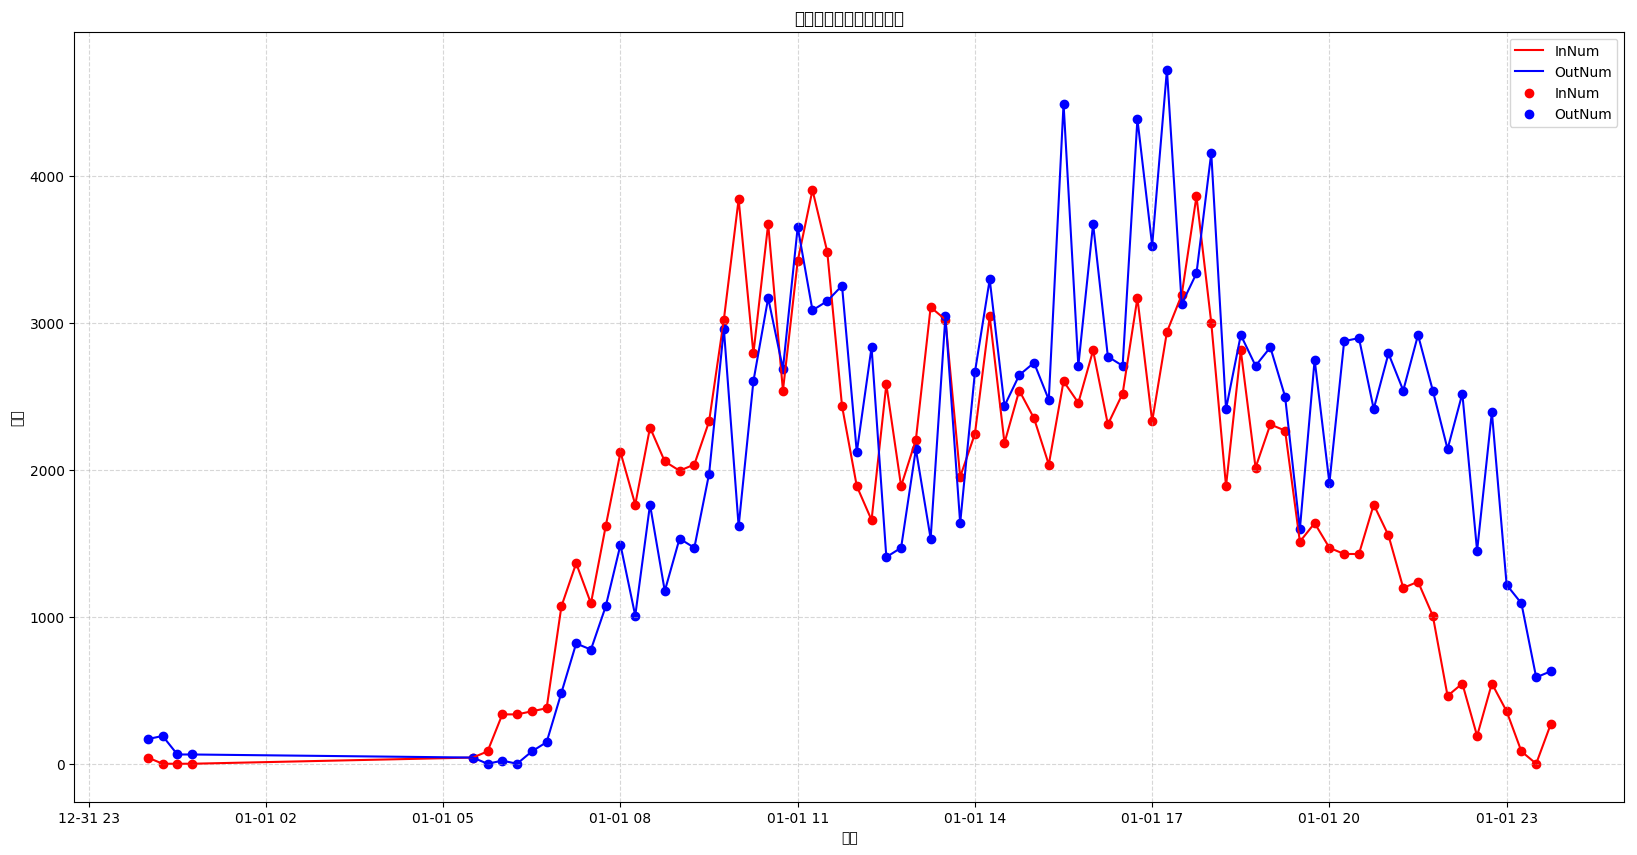

In [145]:
# 画图
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文

plt.figure(figsize=(20, 10), dpi=100)

plt.plot(t['Time'], t['InNum'], c='red', label="InNum")
plt.plot(t['Time'], t['OutNum'], c='blue', label="OutNum")

plt.scatter(t['Time'], t['InNum'], c='red', label="InNum")
plt.scatter(t['Time'], t['OutNum'], c='blue', label="OutNum")

plt.legend(loc='best')
plt.yticks()
plt.xticks()
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel("时间")
plt.ylabel("人数")
plt.title("一天一个站点的时间分布")
plt.show()


可以看出11点和5点左右是高峰期,或8点和七点左右，其中应该有月份和工作日的影响

TypeError: no numeric data to plot

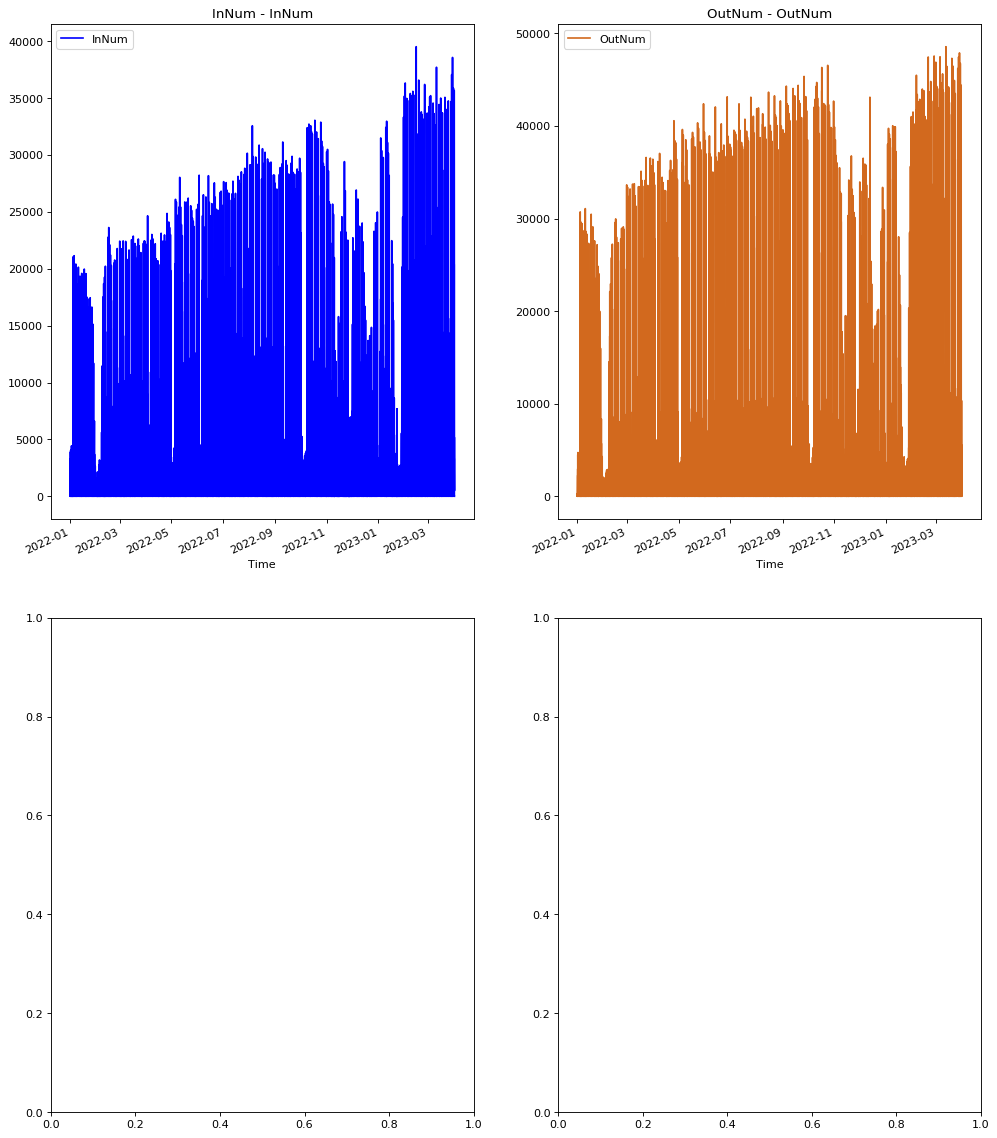

In [139]:
titles = [
    "InNum",
    "OutNum",
    "Station",
]

feature_keys = [
    "InNum",
    "OutNum",
    "Station",
]

colors = [
    "blue",
    "chocolate",
    "green",
]

date_time_key = "Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=2, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i//2, i%2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

In [ ]:
!pip install paddlets -t /home/aistudio/external-libraries

In [158]:
import paddle
from paddlets.datasets.tsdataset import TSDataset
from paddlets.transform import TimeFeatureGenerator, StandardScaler
from paddlets.models.forecasting import LSTNetRegressor
from paddlets.metrics import MAE
import warnings
warnings.filterwarnings('ignore')

赛题要求是预测A到G总共7个站点的客流量，选择了每个站点数据独立训练模型的方式，将7个站点的数据分别放入模型中训练得到7个模型，再分别调用7个模型对7个站点的数据进行预测，最后将预测数据合并。
因此，要对每个数据的站点的数据单独提取。

In [169]:
station = "B" # 站点
dataset_df = df[df['Station']==station]

dataset_df.head()


,Time,Station,InNum,OutNum
5,2022-01-01 00:00:00,B,42,168
10,2022-01-01 00:15:00,B,0,189
17,2022-01-01 00:30:00,B,0,63
22,2022-01-01 00:45:00,B,0,63
36,2022-01-01 05:30:00,B,42,42


构建TSDataset
    TSDataset 是 PaddleTS 中一个主要的类结构，用于表示绝大多数的时序样本数据，并作为PaddleTS其他算子的输入以及输出对象。TSDataset支持对csv文件、json、dataframe格式的读取，同时支持split切片、plot绘图等操作.
    因为时序预测要求数据连续，但广州地铁的运营时间为6:00-24:00，在0:00-6:00时间段存在数据空白，因此我们需要对这一部分的数据进行填充。PaddleTS的TSDataset为我们提供了fill_missing_dates参数，我们可以利用这个参数，将缺失值填充为0。

In [170]:
dataset_df = TSDataset.load_from_dataframe(
    dataset_df,
    time_col='Time', #时间序列
    target_cols=['InNum','OutNum'], #预测目标
    freq='15min',
    fill_missing_dates=True,
    fillna_method='zero'
)

可以看出，地铁客流量有一定的波动规律，存在明显的高峰和低谷，我们可以用.summary()函数查看数据的分布情况。

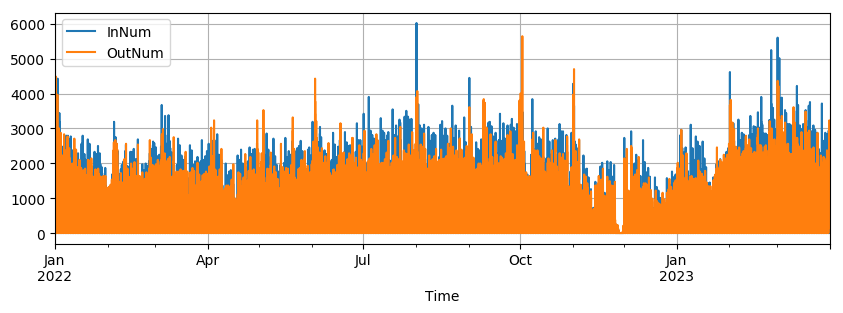

In [25]:
dataset_df.plot()


In [24]:
dataset_df.summary()

,InNum,OutNum
missing,0.000000,0.000000
count,43680.000000,43680.000000
mean,636.491827,642.653365
std,645.261955,596.891788
min,0.000000,0.000000
25%,21.000000,21.000000
50%,525.000000,588.000000
75%,1008.000000,1008.000000
max,6027.000000,5649.000000


TSDataset是支持数据切片的，但与python原生和numpy的切片操作不同，TSDataset的切片操作更便捷，可以直接通过时间序列进行切片。下面我将数据以2023年2月5日23时45分为分界时间节点分为训练集和验证集，再将验证集以2023年3月29日23时45分为节点分出测试集供后面数据模型效果验证。

In [119]:
dataset_train, dataset_val_test = dataset_df.split("2023-02-05 23:45:00")
dataset_val, dataset_test = dataset_val_test.split("2023-03-29 23:45:00")

In [120]:
scaler = StandardScaler()
scaler.fit(dataset_train)
dataset_train_scaled = scaler.transform(dataset_train)
dataset_val_test_scaled = scaler.transform(dataset_val_test)
dataset_val_scaled = scaler.transform(dataset_val)
dataset_test_scaled = scaler.transform(dataset_test)

使用的是LSTM长短期记忆网络模型
参数说明：
- in_chunk_len：模型输入的时间步数
- out_chunk_len：模型输出的时间步数
- max_epochs：最大迭代训练次数
- patience：early stop的手段之一，超过n轮迭代后指标仍无提升即停止训练
- eval_metrics：评估指标，这里选用的是赛题要求的MAE
- optimizer_params：训练参数，主要配置learning_rate


In [28]:
paddle.seed(2023)
model = LSTNetRegressor(
    in_chunk_len = 4*24,
    out_chunk_len = 4*24,
    max_epochs = 200,
    patience = 20,
    eval_metrics =["mae"],
    optimizer_params= dict(learning_rate=3e-3)
)

In [29]:
model.fit(dataset_train_scaled, dataset_val_scaled)

[2023-05-31 12:52:55,529] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 000| loss: 0.302975| val_0_mae: 0.453594| 0:00:14s
[2023-05-31 12:53:09,605] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 001| loss: 0.260514| val_0_mae: 0.449192| 0:00:28s
[2023-05-31 12:53:23,709] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 002| loss: 0.260126| val_0_mae: 0.474598| 0:00:42s
[2023-05-31 12:53:37,981] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 003| loss: 0.261066| val_0_mae: 0.455485| 0:00:56s
[2023-05-31 12:53:52,262] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 004| loss: 0.259113| val_0_mae: 0.453241| 0:01:11s
[2023-05-31 12:54:06,958] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 005| loss: 0.258912| val_0_mae: 0.448874| 0:01:25s
[2023-05-31 12:54:20,947] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 006| loss: 0.258839| val_0_mae: 0.463102| 0:01:39s
[2023-05-31 12:54:35,408] [paddlets.models.common.callb

模型训练完后，我们用测试集的数据对模型的效果进行回测，以此检验模型预测数据与真实数据之间的误差。这一步我们用的是PaddleTS自带的`backtest`函数，return_predicts参数设置为True，可以返回预测结果方便我们与真实数据进行可视化对比。

In [121]:
from paddlets.utils import backtest
from paddlets.metrics import MAE
mae, pred = backtest(data=dataset_test_scaled,
                model=model,
                metric=MAE(),
                return_predicts=True
)


[2023-05-31 15:48:07,914] [paddlets.utils.backtest] [INFO] Parameter 'predict_window' not set, default set to model.out_chunk_len 96
[2023-05-31 15:48:07,916] [paddlets.utils.backtest] [INFO] Parameter 'stride' not set, default set to predict_window 96
[2023-05-31 15:48:07,916] [paddlets.utils.backtest] [INFO] Parameter 'start' not set, default set to model_in_chunk_len 96 + skip_chunk_len 0
[2023-05-31 15:48:07,920] [paddlets.utils.utils] [WARNING] error occurred while import autots, err: No module named 'ray'
Backtest Progress: 100%|██████████| 1/1 [00:00<00:00, 45.88it/s]


In [122]:
_, ground_truth = dataset_test_scaled.split("2023-03-30 23:45:00")

我们用2023年4月16日的数据预测4月17日的C站点客流量，再与4月17日的真实客流量数据做对比，可以看出数据趋势整体一致，但在瞬时波动比较大的峰值数据区间上，模型预测的数据离真实数据还有一定误差，为了衡量预测值和真实值之间的差距，我们可以查看一下MAE指标。

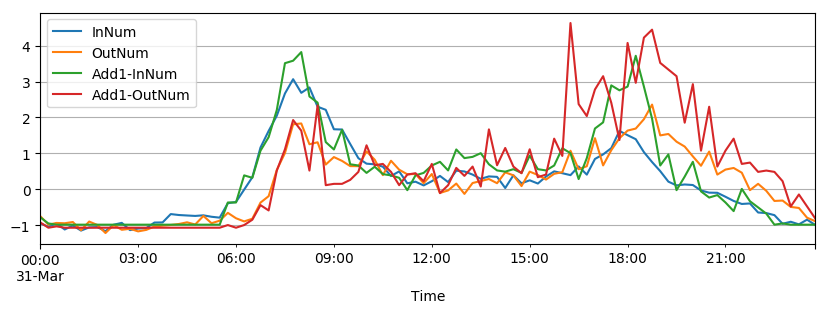

In [123]:
pred.plot(add_data = ground_truth)

In [124]:
#查看评估指标
mae

{'InNum': 0.35413062624281283, 'OutNum': 0.5523984303905642}

图像y轴坐标数值都比较小，这是由于没有将数据反标准化导致的。因此，我们需要用scaler.inverse_transform方法对预测数据进行反标准化处理。
发现有一些数据值是小于0的，而且同时很多数据值都是浮点型，这是由于我们用的是自回归建模方法，但负值的数据是明显不合理的。因此要做到以下两点
1.将负值改为0；
2.将浮点数类型转化为整数类型



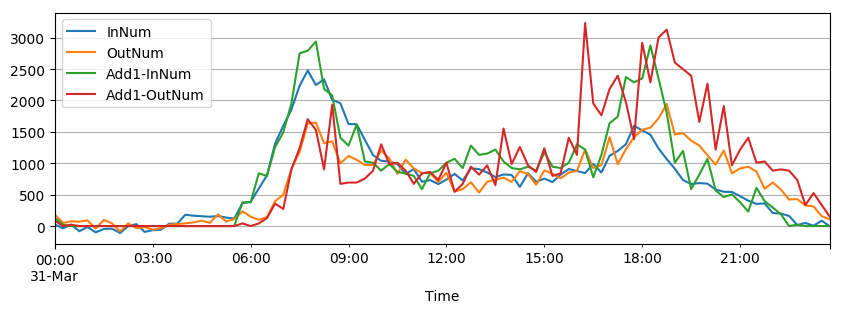

In [125]:
ground_truth_inverse = scaler.inverse_transform(ground_truth)
pred_inverse = scaler.inverse_transform(pred)
pred_inverse.plot(add_data=ground_truth_inverse)

模型训练完成后，将模型固化成文件保存在本地，方便后续的推理工作。这部分使用的是PaddleTS模型自带的save()函数。同时，也要注意将数据标准化的参数保存，用于后续推理前进行数据预处理。

In [ ]:
import os
import pickle

model_save_path = os.path.join("models/lstm",station)
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)
model.save(os.path.join(model_save_path, "model"))
pickle.dump(scaler, open(os.path.join(model_save_path,"scaler.pkl"),'wb'))

模型推理相对比较简单，第一步先将测试数据集读入，转化为TSDataset类型。

In [40]:
import pandas as pd
from paddlets.datasets.tsdataset import TSDataset
from paddlets.transform import TimeFeatureGenerator, StandardScaler

dataset_test_df = pd.read_csv("data/test.csv")
station = "A" # 站点
dataset_test_df = dataset_test_df[dataset_test_df['Station']==station]

dataset_test_df = TSDataset.load_from_dataframe(
    dataset_test_df,
    time_col='Time',
    target_cols=['InNum','OutNum'],
    freq='15min',
    fill_missing_dates=False,
)

dataset_test_df

                     InNum  OutNum
Time                              
2023-04-15 00:00:00     10       5
2023-04-15 00:15:00      2       1
2023-04-15 00:30:00      0       1
2023-04-15 00:45:00      0       0
2023-04-15 01:00:00      0       0
...                    ...     ...
2023-04-15 22:45:00      0      63
2023-04-15 23:00:00      2      43
2023-04-15 23:15:00      0      24
2023-04-15 23:30:00      0      24
2023-04-15 23:45:00      0      20

[96 rows x 2 columns]

加载标准化处理参数，对测试数据进行标准化预处理。

In [41]:
import pickle
with open("models/lstm/C/scaler.pkl", "rb") as r:
    scaler = pickle.load(r)
dataset_test_scaled = scaler.transform(dataset_test_df)
dataset_test_scaled

                        InNum    OutNum
Time                                   
2023-04-15 00:00:00 -0.778124 -0.869064
2023-04-15 00:15:00 -0.783338 -0.872306
2023-04-15 00:30:00 -0.784641 -0.872306
2023-04-15 00:45:00 -0.784641 -0.873117
2023-04-15 01:00:00 -0.784641 -0.873117
...                       ...       ...
2023-04-15 22:45:00 -0.784641 -0.822050
2023-04-15 23:00:00 -0.783338 -0.838262
2023-04-15 23:15:00 -0.784641 -0.853663
2023-04-15 23:30:00 -0.784641 -0.853663
2023-04-15 23:45:00 -0.784641 -0.856905

[96 rows x 2 columns]

In [42]:
import os
from paddlets.models.model_loader import load

model = load("models/lstm/{}/model".format(station))
res = model.predict(dataset_test_scaled)
res_inversed = scaler.inverse_transform(res)
res_inversed = res_inversed.to_dataframe(copy=True)
res_inversed["InNum"] = res_inversed["InNum"].apply(lambda x:0 if x<0 else int(x))
res_inversed["OutNum"] = res_inversed["OutNum"].apply(lambda x:0 if x<0 else int(x))
res_inversed["Station"] = station # 添加站点标识
res_inversed.index.name = "Time"
# 输出结果文件
if not os.path.exists("./results"):
    os.makedirs("./results")
res_inversed.to_csv("results/{}_result.csv".format(station))
res_inversed.head()

,InNum,OutNum,Station
Time,,,
2023-04-16 00:00:00,0,0,A
2023-04-16 00:15:00,0,0,A
2023-04-16 00:30:00,0,0,A
2023-04-16 00:45:00,0,0,A
2023-04-16 01:00:00,0,0,A


将保存好的模型重新加载，调用.predict函数对测试数据进行预测，对预测结果进行反标准化，再处理负值和浮点型问题即可输出为结果文件。